In [137]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.special
import scipy.optimize
import scipy.stats

# Malleus

You've probably heard this mentioned a few times now.  This is the program that I wrote for my thesis project, it is a "**M**arkov chain monte carlo **A**nalysis using **L**og **L**ikelihood to **E**xtract **U**nderlying information from **S**ystematics" (or to **E**xtract **U**seful **S**tuff, your choice).  Yeah, it's a mouthful, I really wanted a cute acronym.

At its heart, it's just a MCMC sampler (using the Metropolis algorithm) that has lots of bells and whistles to make it "easy" to use on detector data with many measured systematics.  We can implement a scaled down version of it in this notebook pretty easily, and we will.  But we need to cover some bases on probability and Bayesian statistics first.

Hopefully most of this will be familiar, so please don't be insulted that I'm coving a lot of stuff that you already know.  I'm being thorough to make sure we're using the same notation and to cover all our bases.

## Probability

At the heart of probability is the idea of a Random Variable and its distribution.  A random variable is an abstract object, which gives specific values when asked.  If our variable is `X`, it doesn't have a value until we ask it.  When we request a value, it gives back some result.  But each time we ask, we'll likely get a different result.

An example is in order - we have a die to roll.  The potential value we would get is `X`.  When we *actually* roll the die, we'll get a specific value (called a "random variate", usually denoted with a lowercase letter, `x` in this case).  So `X` represent the numbers $1$ to $6$ with a certain chance of each, if we have a six sided die (they come in other sizes too!).  The possible answers we could get, and the odds of each, is the _probability distribution_.  For our die, if it's fair, it should be the same for each:

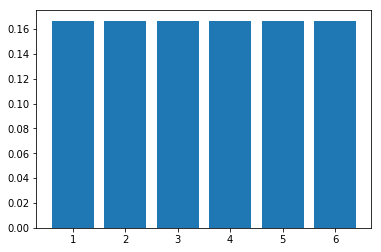

In [138]:
plt.bar([1,2,3,4,5,6],[1/6]*6);

But our die might not be fair.  Maybe we have a fixed die, that is much more likely to give a six:

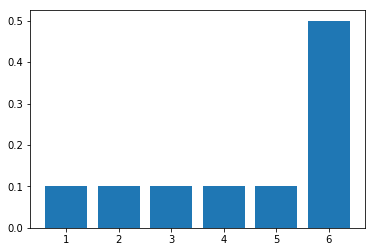

In [139]:
plt.bar([1,2,3,4,5,6], [1/10,1/10,1/10,1/10,1/10,1/2]);

You may have noted that I used $\frac{1}{6}$ for the fair die, instead of some other number (say, $10$ to represent ten rolls coming up for each face after rolling sixty times).  This is important.  We'll see why with some notation. 

We have an event of some nature, with possible outcomes denoted by $i$ (so for the die, there are six, just the numbers, but if we're talking about weather we might have the $i$'s be "clear", "cloudy", "rain", "snow").  Then for each outcome the proportion of the time that it will occur (expressed as a fraction - $\frac{1}{10}$ corresponds to something that happens one tenth of the time, i.e. $10\%$) is called $p_i$.  Since _something_ must happen, the probabilities have the property that they add up to $1$.  Then our rule is:

$$p_i \ge 0 \qquad \qquad \mathrm{and} \qquad \qquad \sum_i p_i = 1$$

(the fact $p_i \le 1$ is implied, we don't need to spell it out).

Note that the probability distribution itself, the combination of $p_i$'s, is denoted $p(X)$ (or $p(Y)$ or whatever our variable is named)

For our fair die, let's roll it a few times.

[5 1 5 4 4 1 6 5 1 3 3 5 3 3 6 6 3 2 5 4 5 1 3 3 3 3 2 3 4 6 4 1 4 5 3 6 6
 4 5 5 6 4 5 4 3 4 2 5 2 4]


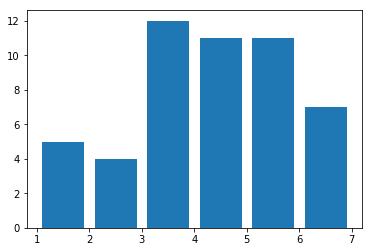

In [140]:
#Note: randint gives numbers in the range [1,7), so the upper value never shows up
rolls = np.random.randint(1,7,size=[50])
print(rolls)
plt.hist(rolls, bins=[1,2,3,4,5,6,7], rwidth=0.8);

That isn't terribly uniform, but it's only $50$ rolls, so we shouldn't be too surprised.  Note that this is now a histogram, which shows how many _times_ each _outcome_ occurred - we're looking at random variates now, actual rolls.  We rolled that die 50 times and counted how many times each face came up.  This leads us to one interpretation of the probability distribution - if we rolled the die an infinite number of times, what would the histogram look like.  This is called the "frequentist" interpretation, and is usually what you see in an intro probability course.

Let's try it again with $100000$ rolls and see if we do better (I'm not going to write out the roll values).

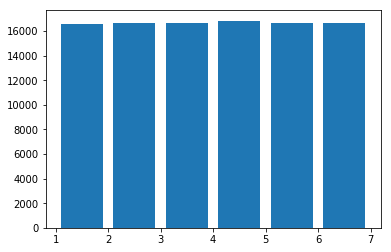

In [141]:
rolls = np.random.randint(1,7,size=[100000])
plt.hist(rolls, bins=[1,2,3,4,5,6,7], rwidth=0.8);

Let's do something slightly more complicated: if we roll *two* dice what happens?

Well, each die can be $1$ to $6$.  If we look at their sum, the range is $2$ to $12$.  But they're not equally likely, since getting a $2$ requires both dice to be $1$, while getting a $7$ can occur many ways ($6$ and $1$, $5$ and $2$, and $3$ and $4$ - in either order for each).

Let's be careful about notation again.  Let's call the first die $D_1$, the second die $D_2$, and the sum $S$.

Then we have a lot of options now for things to look at.  $p(D_1)$ and $p(D_2)$ are the same as before, of course, since rolling one die does not impact the other. But we can now look at a 2-D or joint distribution: $p(D_1, D_2)$.  A little harder to plot, but it just associates a probability with each potential pair of outcomes.  There are now $36$ of them:

$$(1,1) \quad (1,2) \quad ... \quad (2,1) \quad (2,2) \quad ... \quad (6,5) \quad (6,6)$$

Since each of these is equally likely (again, the dice don't talk to each other), each has a probability of $\frac{1}{36}$.

We can use this to get our probabilities of our sums - each of these will have a sum, so we'll have $36$ sums, but they won't be unique.  Those that are the same, we just add their probabilities together.  Let's do that in code.

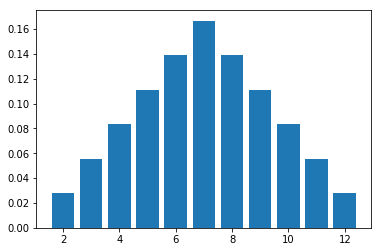

In [142]:
values = list(range(2,13))
probs = {i: 0 for i in values}

for d1 in range(1,7):
    for d2 in range(1,7):
        probs[d1+d2] += 1/36
        
plt.bar(values, [probs[i] for i in values]);

And, of course, we can simulate this by rolling a whole bunch of pairs of dice.

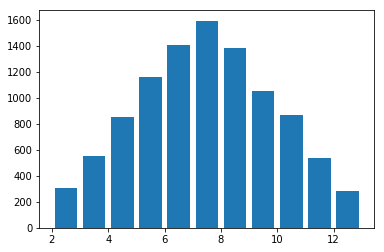

In [143]:
d1_rolls = np.random.randint(1,7,size=[10000])
d2_rolls = np.random.randint(1,7,size=[10000])
sums = d1_rolls + d2_rolls
plt.hist(sums, bins=range(2,14), rwidth=0.8);

## Conditional Probabilities

Ok, that's a probability.  But we can be more specific - we can ask what the probability of something is *given that* something else is true.  This is a conditional probability.  For the weather example, we know that snow is much more likely if the temperature is below freezing.  We can write this more formally:

$$p(W=\mathrm{snow}\:|\:T < 32 \deg F) > p(W=\mathrm{snow}\:|\:T > 32 \deg F)$$

Where the vertical bar (called a "pipe" or a "bar") denotes "given that".  For our dice, we might ask the probability for a given number coming up on the first die, given that the sum is a particular number.  Let's look at two examples: if the sum is $3$, and if the sum is $7$.  We'd expect, for the $3$, that only $1$ or $2$ are possible, whereas for the $7$ we'd likely expect it to be pretty uniform.  Let's find out.

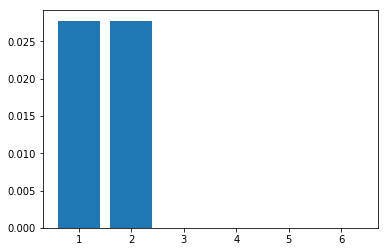

In [144]:
#Sum of 3
probs = {i:0 for i in range(1,7)}
for d1 in range(1,7):
    for d2 in range(1,7):
        if(d1+d2 == 3):
            probs[d1] += 1/36

plt.bar(range(1,7), [probs[i] for i in range(1,7)]);

Uh oh, our probabilites aren't adding up to $1$.  That's ok, we can fix that by simply dividing by the sum of all the $p$'s.  We'll do that for the other sum.

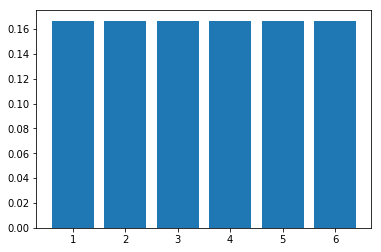

In [145]:
#Sum of 7
probs = {i:0 for i in range(1,7)}
for d1 in range(1,7):
    for d2 in range(1,7):
        if(d1+d2 == 7):
            probs[d1] += 1
total = sum(probs.values())
for i in probs:
    probs[i] = probs[i] / total

plt.bar(range(1,7), [probs[i] for i in range(1,7)]);

Now let's do something a bit odder - let's ask for the distribution of the sum, given that _either_ die is even.

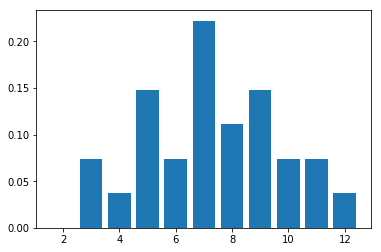

In [146]:
#Sum when either die is even
probs = {i:0 for i in range(2,13)}
for d1 in range(1,7):
    for d2 in range(1,7):
        if(d1 % 2 == 0 or d2 % 2 == 0):
            probs[d1 + d2] += 1
total = sum(probs.values())
for i in probs:
    probs[i] = probs[i] / total

plt.bar(range(2,13), [probs[i] for i in range(2,13)]);

At this stage, we could play with this more - try three dice, or other conditions like the _difference_ of the dice is a particular value, or either die is 3, etc.  But hopefully this has gotten the point across.

## Continuous distributions

So far, we've been dealing with discrete distributions, one that can only take on specific values (like the numbers of a die).  What about something that can take on _any_ value in a certain range?  Say, for example, the outside temperature - this could be any value, within a certain range of reasonable values (it can't be below absolute zero, or over a million degrees, since that's less "weather" and more "apocalypse").  You might, at this stage, say "but the weather isn't a random variable, it's determined by an immensely complex system".  While you're right, I'll also counter with "have you ever seen a weather report?".  And we can also talk about it as if it were a random variable anyway, since the system is so chaotic as to be effectively unpredictable, and weather models only predict probabilities of certain outcomes.

That said, we can take a more concrete example.  Let's say you measure how long something is with a ruler.  You'll measure a value, but it will have an uncertainty - both because you can't measure with infinite precision, and because there's always some chance for error.  If I measure that it's $2.54\:cm$, that means the real value could have been $2.540034\:cm$, or $2.538572\:cm$, or $2.550123\:cm$ (though hopefully that latter is much less likely).  So each potential number has a probability, but there are an infinite number of numbers, so we can't write out a list with a probability for each.  Instead, we need a function called a "probability density function" or pdf, also denoted $p(X)$ (hopefully whether it's discrete or continuous will be clear from context).

The biggest distinction here is talking about the probability of a specific number is pretty meaningless, instead we look at probabilities for a range of numbers (say, what is $p(2.539 < x < 2.541)$).

Let's look at the most common one to run in to: the Normal distribution, also called a Gaussian distribution.  It's strongly peaked around a central value, and falls off as you go away.  If we had measured $2.54 \pm 0.005\:cm$, it would be a Gaussian distribution with mean $2.54$ and width $0.005$.  The formula is

$$p(x) = \mathcal{N}(x\:|\:\mu,\sigma) = 
\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right)$$

the $\mathcal{N}(x\:|\:\mu,\sigma)$ is just a name for the formula for later.

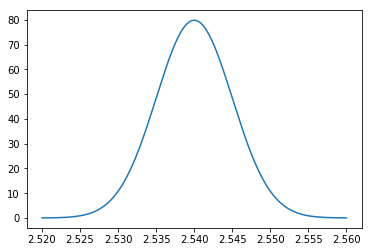

In [147]:
x = np.linspace(2.52,2.56,1000)
mu = 2.54
sigma = 0.005
px = np.exp(-np.square(x - mu) / (2*sigma*sigma)) / np.sqrt(2*np.pi*sigma*sigma)
plt.plot(x,px);

And our constraint has changed - each point must be positive, but it's now _the integral_ that must be $1$, and we note that an individual point can have a value greater than $1$, since it's the integral that matters now.

This is the probability distribution for the real length we tried to measure.  What does that mean?  The real value is a thing that exists out in the real world, what does that mean to have a probability for it?  Well, there are two different interpretations that are popular, the _frequentist_ and the _Bayesian_.  We'll discuss the difference in the next section.

How about taking random variates from this?  They'll be _any_ real number, but with decreasing chance of coming up as we move away from the center of the distribution.  There are general methods for doing this, but we're not going to bother for now as we can just use the normal distribution built in to `scipy`.  Let's look at a few, then draw a bunch in to a histogram.

[2.54025056 2.54200764 2.53632511 2.54364653 2.54224211 2.53535114
 2.54749427 2.54156419 2.54729774 2.54642682]


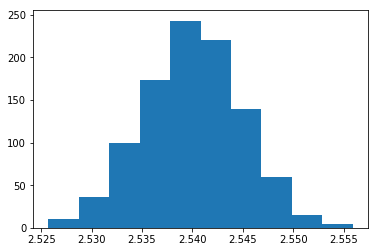

In [148]:
print(scipy.random.normal(mu,sigma,size=10))
plt.hist(scipy.random.normal(mu,sigma,size=1000));

## Bayesian and Frequentist

Well, what does it mean?

If you ask a frequentist, the answer is "if we repeated this measurement over and over, the answers we get would be distributed like that graph, and the real value would be at the peak", and then go on to have a long conversation about hypothesis tests.

If you ask a Bayesian, the answer is "the graph is a measurement of how likely we _think_ each value is to be the real value - higher $p$ indicates we think that value is a better bet for the real value".

This sounds very philosphical, but has a very real implication - the Bayesian is perfectly happy to treat that graph as a probability distribution for the real value (which isn't a _random variable_ per se), where the frequentist would instead want to avoid that by looking to what we can do if we repeat measurements.

Central to a lot of Bayesian statistics is Bayes' Theorem.  It states

$$p(Y\:|\:X) = \frac{p(X\:|\:Y)\:p(Y)}{p(X)}$$

This relates the conditional probabilities to each other.  An example is in order

$$p(T < 32\:|\:snow) = \frac{p(snow\:|\:T < 32)\:p(T < 32)}{p(snow)}$$

So, if we know how likely it is to snow if it's below $32$, and we know how often it's that cold, we can figure out how likely it is to be below $32$ if it's snowing.  The $p(snow)$ in the bottom is an overall normalization factor to make sure that our probabilities work out to sum up to $1$.  Each piece has a name: $p(Y\:|\:X)$ is the posterior (you can chuckle now and get it out of the way), $p(X\:|\:Y)$ is the likelihood, $p(Y)$ is the prior, and $p(X)$ is the evidence.  We'll see each of their roles (other than the evidence, which just normalizes) in a bit.

Note that Bayes' theorem doesn't make a lot of sense in the frequentist framework, if either $X$ or $Y$ is the thing we're setting out to measure (i.e. a physical quantity).

## Statistics

So far we have only been dealing with situations where we already know everything - we know the die is fair, or if it isn't we know the distribution.  That isn't how things work in the real world, usually.  We would instead have a die and want to know if it's fair, or we measure something and want to know what that measurement tells us about the real value of the thing we measured.  This is the field of statistics.

Let's start with the simplest example available - a coin flip.  If we flip a coin, there are two possibilities - heads or tails.  If the coin is fair, each will have probability $\frac{1}{2}$.  Since we know $p_T = 1 - p_H$, we'll only worry about $p_H$ ($H$ is "heads", in case that wasn't obvious).

Well, now we have to figure out how to get $p_H$ when all we can do is flip the coin.  The most obvious thing is to flip the coin a bunch and see what percentage of the time we got heads.  This is the most basic kind of statistic.  And that will give us the "correct" answer, but with some uncertainty - if we only flip it ten times, we might get unlucky and get six or seven heads, and we need to know how likely that is.

We now have to think about not just the probability of an individual coin toss, but the probability of a bunch of coin tosses.  This is the Binomial distribution, which we can quickly derive.  If we flip the coin three times, we have four possible outcomes: 0 heads, 1 head, 2 heads, or 3 heads.  But they're not all equal.  Getting one head requires us to get one head and two tails, so it has $p(1\:\mathrm{head}) = p_H^1 (1 - p_H)^2$.  But there are three ways it could happen (one head, then two tails; a tail, a head, then a tail; or two tails then a head).  Let's map this out.


| $N_{heads}$ | prob of particular flip | possible orders | prob of total flips |
| ------------- | ------------- | ------------- | ------------- |
| 0 | $p_H^0 (1 - p_H)^3$ | T T T | $(1 - p_H)^3$ |
| 1 | $p_H^1 (1 - p_H)^2$ | H T T,  T H T,  T T H | $3 p_H^1 (1 - p_H)^2$ |
| 2 | $p_H^2 (1 - p_H)^1$ | H H T,  H T H,  T H H | $3 p_H^2 (1 - p_H)^1$ |
| 3 | $p_H^3 (1 - p_H)^0$ | H H H | $p_H^3 $ |

We actually know this more generally - if we have $n$ coin flips, the number of ways we can get $k$ heads is $n$ _choose_ $k$ (the permutations).  So we can write out the general formula

$$p(k\:|\:n, p_H) = {n\choose k} p_H^k (1-p_H)^{n-k}$$

At this stage, the Bayesian and Frequentist approaches diverge.  In the Frequentist approach, we'll talk about values that we can rule out to a certain level of precision through a method called hypothesis tests.  We have to set a level of "confidence" and work from there - if we say 95% (a common choice), then we say we can rule out those $p_H$'s which have less than 5% chance of giving the result we saw.  So, for example, if we flipped 3 times and saw 2 heads, we can rule out $p_H = 0$ and $p_H = 1$ right away, but also things like $p_H = 0.99$.  There's a methodology for doing this, but I'm a Bayesian and this is a document about Bayesian stuff, so we're not going to.

The Bayesian approach treats the $p_H$ itself as a random variable (which is admittedly a touch odd if you think of it as meaning "something which gives different values when asked", but we're starting to move to the interpretation of "something we don't have full knowledge of").  We can get out a probability distribution for $p_H$ by sort of inverting the process here.  We know we got 2 heads, let's make a graph of what $p(2\:|\:3, p_H)$ is for each $p_H$

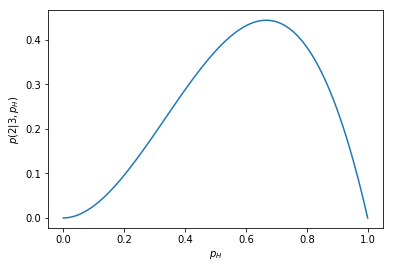

In [149]:
pH = np.linspace(0,1,100)
prob2 = 3*pH*pH*(1-pH)
plt.plot(pH, prob2)
plt.xlabel("$p_H$")
plt.ylabel("$p(2 | 3, p_H)$");

Not super surprising here - it's more likely to be on the high side, but still fairly consistent with a fair coin $p_H = 0.5$.  Note the rapid fall off as you move toward $1$, this is because the odds of getting _any_ tails falls off rapidly as that $p_H$ increases.

Also, this isn't a properly normalized probability anymore.  This is easily fixed (we just divide by the integral), but we'll hold off on that since, strictly speaking, we cheated a bit here.  We'll see why in the next section.

But before we go on, we should take a moment to mention something very important in traditional statistics - the Central Limit Theorem.  This states that basically any probability distribution, if you repeatedly sample from it and sum or average the things you get (say, for example, finding the average number of heads from many coin flips) looks more and more like a Gaussian as you take more samples.  This is nearly a miracle, in terms of computation, since it means we need to study only the Normal distribution to understand most things.  And it has been _extremely_ well studied over the centuries.  This lets us do things like say "if we have $N$ coin flips, the number of heads is given by a normal distribution with $\mu_N = p_H * N$ and $\sigma = \sqrt{p_H*(1-p_H)*N}$ if $N$ is large enough".  Let's make a graph of 100 coin flips with both the binomial formula and that approximation and see how they compare - let's pick $p_H = 0.6$ for our example.

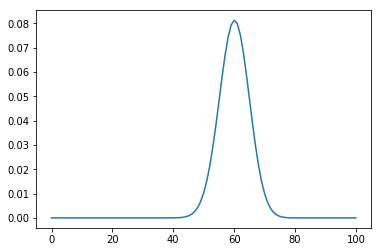

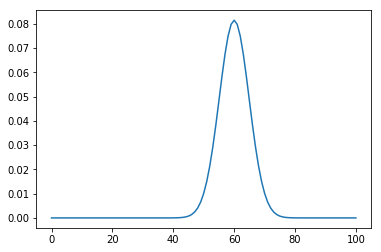

In [150]:
n_flips = 100
n_heads = np.array(range(0,n_flips+1))
pH = 0.6
binomial = [scipy.special.comb(n_flips,n) * pH**n * (1 - pH)**(n_flips-n) for n in n_heads]
plt.plot(n_heads, binomial)
plt.show()
sigma_H = np.sqrt(pH*(1-pH)*n_flips)
approx = 1/np.sqrt(2*np.pi*sigma_H**2) * np.exp(-(n_heads - n_flips*pH)**2 / (2*sigma_H**2))
plt.plot(n_heads, approx);

The two graphs are identical.  Good, math isn't broken.

## Data and fits

This has been pretty abstract so far, with one small bit about real measurements with the Normal distribution.  So let's start there: when we measure something, anything, we have some intrinsic uncertainty.  Often we quote this as a measurement plus an uncertainty, $\mu \pm \sigma_\mu$.  Note the letters I used there, which was fully intentional.  That's because this notation is saying our measurement has a Normal or Gaussian error, and the real value has a Normal probability distribution of mean $\mu$ and width $\sigma_\mu$.  This *does not* have to be the case, it's just the most common situation.  If you've seen error propagation, that's just hiding a bunch of manipulation of Gaussian distributions underneath.

Ok, that's good to know.  But we usually don't measure a single value, we instead measure a bunch of related measurements.  If we measure the same length $100$ times, it's pretty clear what to do - we just average them together.  If, instead, we measure how long a rod is at a bunch of temperatures (things expand as they get hotter, in case you forgot), we need to do something else.

Let's say we measure the length of a rod at a $T_1=10$, $T_2=20$, ..., $T_{10}=100$ degrees C, and note each measurement as $L_i$ (so at $T_1$ we measure $L_1$, etc).  If the rod is made of metal, physics tells us we expect there to be a linear relationship here, so

$$L = L_0 + \alpha T$$

We want to know $\alpha$ for the rod, that's the physical quantity we care about.  Each of our measurements has some uncertainty (we'll not worry about the temperature uncertainty for now).  Let's plot some data.  I've created some data assuming an uncertainty of $0.01\: cm$ on the measurement to make things easy.

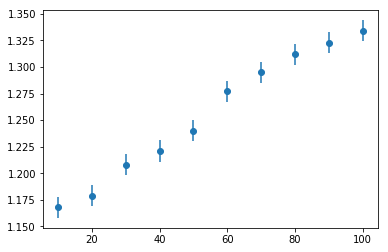

In [151]:
T = np.array([10,20,30,40,50,60,70,80,90,100])
L = np.array([1.168,1.179,1.208,1.221,1.240,1.277,1.295,1.312,1.323,1.334])
#I've created it with a 0.01 cm uncertainty
plt.errorbar(T,L,0.01,fmt='o');

Now what?  Well, we effectively need to fit a line to this data.  There are _many_ techniques to do this, but they mostly hinge on the idea that we have a model for our data (a line, in this case, but it could be more complicated), and some measure of how good a job we're doing.  You've most likely seen the "least squares" method, but let's recap that quickly.

We have the model predicting length from temperature, let's call it $f(T)$ (it's the linear relationship from before).  We'll say how well we're doing by the most obvious route, just subtracting our prediction from our measurement, and adding up our errors - but we'll need all those errors to be positive (so they don't cancel when they sum), so we'll square them.  Let's call their sum $E$ for convenience.

$$E = \sum_i (f(T_i) - L_i)^2$$

Putting in our linear function, we rewrite this as

$$E(\alpha, L_0) = \sum_i (L_0 + \alpha T_i - L_i)^2$$

Note what I did there: $E$ is a function of $\alpha$ and $L_0$, since the $T_i$'s and $L_i$'s are fixed - they're our measurements.  Now to find the value for $\alpha$ from our measurement, we merely need to find the values of $\alpha$ and $L_0$ that minimize $E$. Minimization is a very well developed field and there are a lot of packages you can download to do it for you.  I'll use SciPy here.

Now, you may have noticed that at no point have I used the error on the individual measurements.  We should incorporate that by measuring how far we are off not in terms of raw centimeters, but in "uncertainty units", i.e. by dividing each difference by its respective uncertainty.

$$E(\alpha, L_0) = \sum_i \frac{(L_0 + \alpha T_i - L_i)^2}{\sigma_i^2}$$

Ah, now we've arrived at the familiar formula.  Let's implement it, noting that our uncertainty is the same on each point (not usually the case, but for simplicity here it is).

In [152]:
#We'll need to bundle L_0 and alpha in to a vector (L_0, a)
def error_fun(x):
    return np.square((x[0] + x[1]*T - L)/0.01).sum()

#Second argument is initial guess to start optimization
#Normally you'd compute those, I just picked some
result = scipy.optimize.minimize(error_fun, [1.1,0.001])
print(result)

      fun: 5.0700606698301565
 hess_inv: array([[ 2.33333333e-05, -3.33333333e-07],
       [-3.33333333e-07,  6.06060606e-09]])
      jac: array([-0.01962262,  0.02863121])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 316
      nit: 2
     njev: 76
   status: 2
  success: False
        x: array([1.14633474, 0.00198846])


So we get an optimum, and a bunch of other info as well.  There's a bit of an error message, but we're not going to worry about it for the moment.  Let's plot it

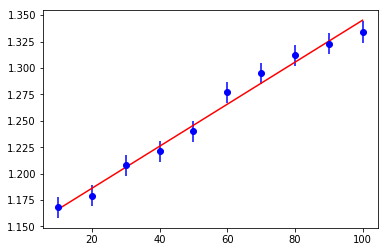

In [153]:
L0, alpha = result.x
plt.plot(T, L0 + alpha*T, 'r')
plt.errorbar(T,L,0.01,fmt='ob');

Ok, not bad at all.  But that value of $\alpha$ is a thing we're trying to measure, so it needs an uncertainty (plus, I know the real value is $0.002$, since I created it).  Now we hit a small impasse - how do we get the uncertainty?  What does it even mean in this context? In essence, what we want to ask is "what other values of $(L_0, \alpha)$ also produce costs close to this minimum".  Yes, that's ill defined.  To be more precise, we'll start by looking at just $\alpha$, so let's plot $E$ vs $\alpha$

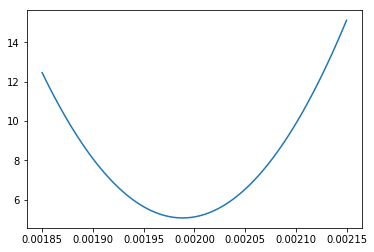

In [154]:
alphas = np.linspace(0.00185,0.00215,100)
errors = [error_fun([L0, a]) for a in alphas]
plt.plot(alphas, errors);

That's a nice parabola, just what you'd expect for a minimum (since the first derivative is zero at a minimum, the linear term in the Taylor expansion goes away, leaving you with a parabola and higher terms).  How do we turn that in to an uncertainty?  The established answer (that we'll derive later) is that this parabola is of the form

$$\frac{(\alpha - \mu_{\alpha})^2}{2 \sigma_{\mu}^2} + E_{min}$$

$\mu_{\alpha}$ is our best-fit value, $\sigma_{\mu}$ is our uncertainty on that, and $E_{min}$ is the value of $E$ at the minimum (this isn't useful for us, but ultimately is some measure of the noise in your data).

If that looks suspiciously like a Gaussian, you're right, that's where it comes from.  More on that later.

This tells us how to get $\sigma$ - we either do another fit, or we figure out what happens when we use different $\alpha$'s - if we put in $\alpha = \alpha_{\mu} \pm \sigma_{\mu}$, we get

$$\frac{(\alpha - \mu_{\alpha})^2}{2 \sigma_{\mu}^2} + E_{min} = \frac{(\pm \sigma_{\mu})^2}{2 \sigma_{mu}^2} + 
E_{min} = \frac{1}{2} + E_{min}$$

Well then, we just need to find out how far we need to go to get an increase of $1/2$, that's pretty easy.  I'll compute it, and I'll draw it all on that same graph from above.

Measured value of α: 0.001988 ± 0.000036


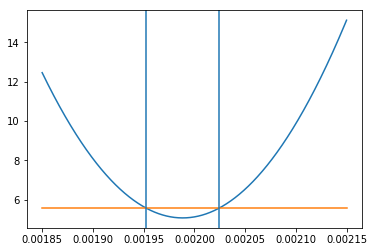

In [155]:
E_min = error_fun([L0,alpha])
alphas = np.linspace(0.00185,0.00215,1000)
errors = np.array([error_fun([L0, a]) for a in alphas])

#Let's do some trickery here to get the closest spots
#We could do a lot better if we tried harder, honestly
error_bounds = alphas[errors < E_min + 0.5][[0,-1]]

plt.plot(alphas, errors)
plt.plot(alphas, [E_min + 0.5 for a in alphas])
plt.axvline(x=error_bounds[0])
plt.axvline(x=error_bounds[1])

print("Measured value of α: {:0.6f} ± {:0.6f}".format(alpha, error_bounds[1] - alpha))

Well then, that's great.  But we're neglecting a few very important points.  First, we fixed $L_0$ to its optimum value, is that legit?  If not, what should we do?  And are we sure it's always going to be a nice parabola?  What do we do if it's not?

To answer the first question, the answer is "probably not".  We can redo this for a different fixed value of $L_0$, and if the two parameters are at all correlated we'll get a different answer.  Let's plot them together to see if they're correlated - this is going to need to be a contour plot, since  we're plotting something instrinsically 3D since $E(L_0, \alpha)$ is a function of two variables.  I'll also put a line at the best fit value of $L_0$ to show where we took our slice.

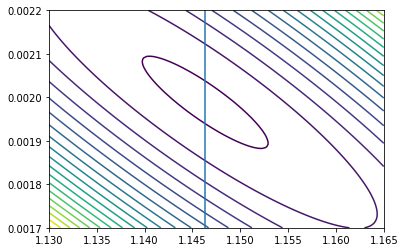

In [156]:
alphas = np.linspace(0.0017,0.0022,100)
Ls = np.linspace(1.13,1.165,100)
[X,Y] = np.meshgrid(Ls,alphas)
Z = np.apply_along_axis(error_fun, -1, np.stack([X,Y],axis=-1))
plt.contour(X,Y,Z,20)
plt.axvline(x=L0);

The fact that this is on a diagonal is a clear sign of the two being correlated (we can compute the actual correlataion coefficient, but we'll need some more tools first).  When we did this, we took a vertical slice basically through the center (the blue line), which doesn't seem representative of the actual uncertainty.

This leads us to our second question: If we can't just do this simple computation of the uncertainty, what can we do? There are techniques we could use involving a lot more work, but I think it's time we take a step back and look at the bigger picture instead.

## Fits from a Bayesian perspective

I said we were going to derive all this, right?  Well, it's time.

First, we go back to that definition of what a measurement of $2.54 \pm 0.01\:cm$ means - it's saying that our measurement represents a Gaussian distribution, with $\mu=2.54$ and $\sigma=0.01$.  This is going to be the cornerstone of what we do from here on - since we have a bunch of measurements (of length in our example), each measurement _represents a draw from a Gaussian_ - that is to say, if we repeated the measurement, we expect that we'd get another draw from the same Gaussian.  Or, more to the point, for a measurement of $L$ with true value $\ell$ and a measurement uncertainty of $\sigma$, then we'd expect that a measurement would be a random draw from

$$p(L\:|\:\ell)  = \mathcal{N}(L\:|\:\ell,\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(L - \ell)^2}{2 \sigma^2}\right)$$

Where we are _defining_ $\mathcal{N}(L\:|\:\ell,\sigma)$ as the normal distribution function (just for shorthand)

And if we had two such measurements, if they were independent of each other (i.e. measuring at one point doesn't impact the other measurements, which is _usually_ the case) then their joint distribution would just be the product of their individual distributions

$$p(L_1, L_2\:|\:\ell_1, \ell_2) = p(L_1\:|\:\ell_1)\:p(L_2\:|\:\ell_2) = \frac{1}{2 \pi \sigma_1 \sigma_2} 
\exp\left(-\frac{(L_1 - \ell_1)^2}{2 \sigma_1^2}\right) \exp\left(-\frac{(L_2 - \ell_2)^2}{2 \sigma_2^2}\right)\\
= \frac{1}{2 \pi \sigma_1 \sigma_2} 
\exp\left(-\frac{(L_1 - \ell_1)^2}{2 \sigma_1^2} - \frac{(L_2 - \ell_2)^2}{2 \sigma_2^2}\right)$$

More generally, for $N$ measurements, we can write this as

$$p(\{L_i\}\:|\:\{\ell_i\}) = \prod_i \mathcal{N}(L_i\:|\:\ell_i,\sigma_i)$$

Note that I'm using the curly braces to denote a set - that's a list of all the $L_i$'s, so I didn't have to write out $L_1, L_2, ..., L_{10}$, and this is now a 10 dimensional joint distribution.  This is a single probability distribution, and any draw from it gives us 10 data points $\{L_i\}$, so this tells us how likely our particular data set was, _given our hypothesis that the true values are the $\{\ell_i\}$'s_.

Well, we can do one better now - we have a formula for what we expect the $\ell_i$'s to be, they're just our linear formula.  Rewriting this we now only have two parameters (after the pipe)

$$\mathcal{L}(\{L_i\}\:|\:L_0,\alpha) = p(\{L_i\}\:|\:L_0,\alpha) = 
\prod_i \mathcal{N}(L_i\:|\:L_0 + \alpha T_i,\sigma_i)$$

And now we have a likelihood, this object is the key.  Why?  Well, if we want to find the "right" values, we just find the ones that maximize the likelihood, i.e. the ones that make our data most likely to have been a draw from the now 10 dimensional distribution. I honestly don't know why it gets that special symbol $\mathcal{L}$, but it is often called that.

Often we deal with the logarithm of the likelihood, just for computational ease.  Note that the logarithm function is monotonic, so that

$$f(x) < f(y) \implies \log(f(x)) < \log(f(y))$$

so if $z$ is where $\log(f)$ is maximum, $f$ is also maximum there.  Let's compute the log of our likelihood, noting that $\log(x\cdot y) = \log(x) + \log(y)$

$$\log\mathcal{L}(\{L_i\}\:|\:L_0,\alpha) = \log\left(\prod_i \mathcal{N}(L_i\:|\:L_0 + \alpha T_i,\sigma_i)\right) =
\log\left(\prod_i \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left(-\frac{(L_0 + \alpha T_i - L_i)^2}
{2 \sigma_i^2}\right)\right)= \\
\sum_i \log\left(\frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left(-\frac{(L_0 + \alpha T_i - L_i)^2}
{2 \sigma_i^2}\right)\right) = 
\sum_i \left(-\frac{(L_0 + \alpha T_i - L_i)^2}{2 \sigma_i^2} - \frac{1}{2}\log(2 \pi\sigma_i^2)\right) = \\
-\sum_i \left(\frac{(L_0 + \alpha T_i - L_i)^2}{2 \sigma_i^2}\right) - 
\sum_i\frac{1}{2}\log(2 \pi\sigma_i^2) = \\
-E(L_0, \alpha) - C$$

Oh look, the log-likelihood is just (the negative of) our $E$ from before, with an additional constant that _does not depend on our parameters_ - it's fixed by our measurement errors.  So the point of this?  We have just proven that minimizing our error function maximizes our probability, it's not just some ad-hoc thing we did.  However, it is absolutely dependent on the idea that our errors are normally (Gaussian) distributed, and independent from each other.  It doesn't work otherwise.

We now have $p(\{L_i\}\:|\:L_0,\alpha)$.  Not exactly what we want - we want to know the distribution of potential values for $L_0$ and $\alpha$ _given that_ we measured $\{L_i\}$.  This looks like a job for Bayes' Theorem.

$$p(L_0,\alpha\:|\:\{L_i\}) = \frac{p(\{L_i\}\:|\:L_0,\alpha)\: p(L_0, \alpha)}{p(\{L_i\})}$$

Well, we have one of those, the likelihood.  The second one is $p(L_0, \alpha)$, the prior.  This is what we use to represent knowledge we have going in, things like "$L_0$ is positive" or "we've already done some measurement to constrain the values" or "the value of $\alpha$ can't be too insane - if it was $10^{50}$, it would have broken our equipment instantly".  This is something we always do without realizing it, but we're going to be explicit about it here.  I'm just going to cheat instead and set it to $1$ - all values are equally probable.  This means that I'm allowing for the crazy values mentioned before, but I know our data is _wildly_ inconsistent with them, so it won't be a problem. We probably should set $p(\alpha)$ to be normal, with mean $0$ and some large width that constrians it to be physical (say width $10^6$ or something).  Again, it won't matter here.

Then there's the third term, $p(\{L_i\})$, the evidence.  We're going to treat it as a normalization term and ignore it, since it doesn't depend on $L_0$ or $\alpha$ at all.  I'm going to lump it in with our $C$ above.

Well, what has this bought us?  _A lot_.  We now have a probability distribution for our parameters!

$$p(L_0,\alpha\:|\:\{L_i\}) = C_{total}\exp(-E(L_0,\alpha))$$

where

$$C_{total} = \frac{\exp(-C)}{p(\{L_i\})}$$

is, again, whatever we need to do to get this to be a proper probability distribution, i.e.

$$\iint p(L_0,\alpha\:|\:\{L_i\})\: dL_0\:d\alpha = \iint C_{total}\exp(-E(L_0,\alpha))\: dL_0\:d\alpha = 1$$

This looks like a bit of an ugly customer, but it turns out to not be so bad (ish, the algebra is still a mess).  Basically, since our fit function is linear, we get to play some math games that make things work out ok.  This is where the formula for getting the uncertainty came from before - we recognize that $p = C \exp(E)$, so near the minimum we can do a quadratic expansion of $E$ in each variable to get a Gaussian.

We'll note that in more than one dimension, Gaussians get more complicated.  For $k$ dimensions, the formula becomes

$$p(\vec{x}) = \frac{1}{\sqrt{(2\pi)^k \det(\Sigma)}} 
\exp\left(-\frac{1}{2}(\vec{x} - \vec{\mu})^T\Sigma^{-1}\,(\vec{x} - \vec{\mu})\right)$$

where $\vec{\mu}$ is a $k$ dimensional vector of means (it determines the $k$ central values, i.e. the peak of each variable) and $\Sigma$ is a real, positive definite $k$ by $k$ matrix (this is the higher dimensional equivalent of the $\sigma$ from before, it allows for linear correlations between the variables).

If we specify to our 2D case, it simplifies a lot.

If we write out the _inverse_ matrix (the components of this are easy to get)

$$\Sigma^{-1} = \begin{bmatrix}\Sigma^{-1}_{11} && \Sigma^{-1}_{12}\\ \Sigma^{-1}_{21} && 
\Sigma^{-1}_{22}\end{bmatrix}$$

If it's positive definite, $\Sigma^{-1}_{12} = \Sigma^{-1}_{21}$ (this is true in general, both $\Sigma$ and 
$\Sigma^{-1}$ have to be symmetric).

$$p(x,y) = C \exp\left(-\frac{1}{2}(\Sigma^{-1}_{11} (x-\mu_x)^2 + 2\Sigma^{-1}_{12} (x-\mu_x) (y-\mu_y) + 
\Sigma^{-1}_{22} (y-\mu_y)^2)\right) =\\
C\exp\left(-\frac{1}{2}(\Sigma^{-1}_{11} x^2 + \Sigma^{-1}_{22} y^2 - 
(2 \Sigma^{-1}_{11} \mu_x + 2 \Sigma^{-1}_{12} \mu_y) x
-(\Sigma^{-1}_{22} \mu_y + 2 \Sigma^{-1}_{12} \mu_x) y + 2 \Sigma^{-1}_{12} x y + 
(\Sigma^{-1}_{11} \mu_x^2 + 2 \Sigma^{-1}_{12} \mu_x \mu_y + \Sigma^{-1}_{22} \mu_y^2) )\right)$$

Ok, we have a form.  In general, at this stage we can recognize that this looks exactly like the second order Taylor expansion of $E$ about the minimum - this is how fitting utilities that get uncertainties usually do it, since computing numerical derivatives isn't so awful to do (though it has its issues).

If we square out our $E$, we get ~~a giant mess~~ just a quadratic function. Let's do that.

$$p(L_0,\alpha) = C\exp\left(-\sum_i\frac{(L_i - L_0 + \alpha T_i)^2} {2 \sigma_i^2}\right) = 
C\exp\left(-\sum_i\frac{L_i^2 + L_0^2 + \alpha^2 T_i^2 - 2 L_i L_0 + 
2 L_i \alpha T_i - 2 L_0 \alpha T_i} {2 \sigma_i^2}\right) = \\
C\exp\left(- \frac{1}{2}\left(L_0^2\sum_i \frac{1}{\sigma_i^2} + \alpha^2 \sum_i \frac{T_i^2}{\sigma_i^2}
-L_0 \sum_i\frac{2 L_i}{\sigma_i^2} + \alpha \sum_i \frac{2 L_i T_i}{\sigma_i^2}
- L_0 \alpha \sum_i \frac{2}{\sigma_i^2} + \sum_i \frac{L_i^2}{\sigma_i^2} \right) \right)
$$

At this stage, we could match and solve to get our equation.  But the important insight here is that they're the same form, so our equation is a Gaussian for $\alpha$ and $L_0$ as well.  Actually, by solving we'll get the exact answers to this particular problem, and just have a formula to use in the future - this has been done more generally for the problem of least squares with a linear function, you can look it up.

Since we have the function already, we should be able to compute the three components of our $\Sigma$ from that without messing about with all the formulas above.  First, let's plot the probability itself with a line through the best fit $L_0$ we found before.

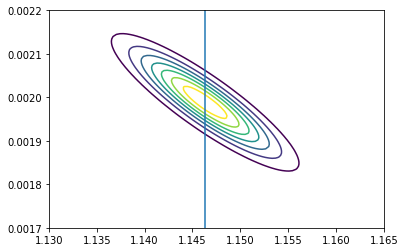

In [157]:
alphas = np.linspace(0.0017,0.0022,100)
Ls = np.linspace(1.13,1.165,100)
[X,Y] = np.meshgrid(Ls,alphas)
Z = np.apply_along_axis(lambda x: np.exp(-error_fun(x)), -1, np.stack([X,Y],axis=-1))
plt.contour(X,Y,Z)
plt.axvline(x=L0);

Now, earlier I said that the parabola we had was of the form

$$E(\alpha) = \frac{(\alpha - \mu_{\alpha})^2}{2 \sigma_{\mu}^2} + E_{min}$$

This is what you would get if you had only one parameter, so your distribution (expanded to second order near the minimum) was Gaussian, hopefully this is clear now as to why.  Well, we don't have that, we have two parameters, and hence a 2D Gaussian with a matrix $\Sigma$ to deal with.  Let's expand $E$ to second order about the minimum:

$$E(L_0, \alpha) \approx E_{min} + \left. \frac{\partial^2E}{\partial \alpha^2}\right|_{min}(\alpha - \alpha_{min})^2
+ \left. \frac{\partial^2E}{\partial L_0^2}\right|_{min} (L_0 - L_{0,min})^2 + 
2\left. \frac{\partial^2E}{\partial \alpha \partial L_0 }\right|_{min} (L_0 - L_{0,min}) (\alpha - \alpha_{min})$$

And we again get something familiar - this is the expansion of our 2D Gaussian, with

$$\Sigma^{-1} = \begin{bmatrix}\left. \frac{\partial^2E}{\partial \alpha^2}\right|_{min} && 
\left. \frac{\partial^2E}{\partial \alpha \partial L_0 }\right|_{min}\\ 
\left. \frac{\partial^2E}{\partial \alpha \partial L_0 }\right|_{min} && 
\left. \frac{\partial^2E}{\partial L_0^2}\right|_{min}\end{bmatrix}$$

(Note: this object has a name, it's called the Hessian).  Ok, that's good, that gives us a straightforward way to get the matrix out.  We have the $E$ function we created before, we just need to do some numerical derivatives now.

As a quick reminder, (one version of) the definition of a derivative is

$$\frac{\partial f(x,y)}{\partial x} = 
\lim_{\Delta x\rightarrow 0}\frac{f(x+\Delta x,y) - f(x-\Delta x,y)}{2 \Delta x}$$

There are many ways to do this numerically, but we want a second derivative anyway.  Here's a common implementation of a numerical second derivative (it's basically doing the thing above twice)

$$\frac{\partial^2 f(x,y)}{\partial x^2} = 
\lim_{\Delta x\rightarrow 0}\frac{f(x+2\Delta x,y) - 2 f(x,y) + f(x-2\Delta x,y)}{4 \Delta x^2}$$

$$\frac{\partial^2 f(x,y)}{\partial x \partial y} = 
\lim_{\Delta x\rightarrow 0,\Delta y\rightarrow 0}\frac{f(x+\Delta x,y + \Delta y) - f(x - \Delta x,y + \Delta y) - 
f(x+\Delta x,y - \Delta y) + f(x - \Delta x, y - \Delta y)}{4 \Delta x \Delta y}$$

$$\frac{\partial^2 f(x,y)}{\partial y^2} = 
\lim_{\Delta y\rightarrow 0}\frac{f(x,y+2\Delta y) - 2 f(x,y) + f(x,y-2\Delta y)}{4 \Delta y^2}$$

Ok, we can do that numerically with our $E$

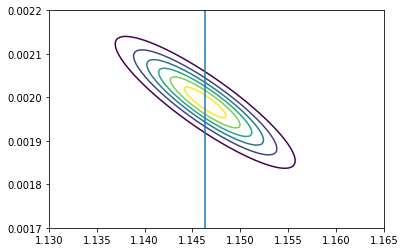

In [158]:
d_alpha = (0.0022 - 0.0017) / 100
d_L0 = (1.165 - 1.13) / 100
dEdalpha2 = (error_fun([L0, alpha + 2*d_alpha]) - 2*error_fun([L0, alpha]) + error_fun([L0, alpha - 2*d_alpha])) / (4*d_alpha*d_alpha)
dEdL02 = (error_fun([L0 + 2*d_L0, alpha]) - 2*error_fun([L0, alpha]) + error_fun([L0 - 2*d_L0, alpha])) / (4*d_L0*d_L0)
dEdL0dalpha = (error_fun([L0 + d_L0, alpha + d_alpha]) - error_fun([L0 + d_L0, alpha - d_alpha]) - error_fun([L0 - d_L0, alpha + d_alpha]) + error_fun([L0 - d_L0, alpha - d_alpha])) / (4*d_alpha*d_L0)

def Gauss2D(x):
    dalpha = x[1]-alpha
    dL0 = x[0] - L0
    return np.exp(-0.5*(dEdalpha2*dalpha*dalpha + 2*dEdL0dalpha*dL0*dalpha + dEdL02*dL0*dL0))

#Let's plot it and make sure it's the same
alphas = np.linspace(0.0017,0.0022,100)
Ls = np.linspace(1.13,1.165,100)
[X,Y] = np.meshgrid(Ls,alphas)
Z = np.apply_along_axis(lambda x: Gauss2D(x), -1, np.stack([X,Y],axis=-1))
plt.contour(X,Y,Z)
plt.axvline(x=L0);

Ok, we got in to the weeds a bit there.  The important thing was that our probability is just $\exp(-E)$, and that we can Taylor expand $E$ to quadratic order to get a normal-like distribution near the minimum.  Also, we see that just doing this for each variable separately is not sufficient, since a full multi-dimensional Gaussian has more parameters than that.

Well, what _should_ we do then? The answer turns out to be "it depends" (of course).  We need to make a decision about each variable: do we want to use it, or do we not care about it?  If it's the former, then we _must_ report the full $\Sigma$ matrix to be doing the right thing.  Or give people the full distribution itself, since the normal distribution is usually only an approximation near the minimum (more on this later).

On the other hand, if we don't care about them, they're called "nuisance parameters".  We want to remove their influence, not worry about how they're correlated.

In our example, we cared about $\alpha$ and not about $L_0$.  We want to get rid of the $L_0$ and get the more appropriate uncertainty, since the $L_0$ is an artifact of our experiment, the length of the particular rod we chose to use, while $\alpha$ should be a fairly universal constant.  Well, we have the joint distribution now, $p(L_0,\alpha)$.  If we look at our graph above, we'll realize that we'll get a different effective $\sigma_\alpha$ for each choice of $L_0$, since we get a different Gaussian for $\alpha$.  To get what we want, we'll just need to do a weighted average of these distributions, with the weight given by how likely that value of $L_0$ is:

$$p(\alpha) = \int p(\alpha\:|\:L_0) p(L_0)\,dL_0 = \int p(\alpha, L_0)\,dL_0$$

You probably aren't surprised that this is just an integral across the full joint distribution.  Of course, here we could even do the integral exactly with the partials we computed above (but it's not easy), but instead we'll do it numerically. You might also see the problem - this isn't so bad in 2D but rapidly becomes very hard as the number of parameters increases (this is called "the curse of dimensionality").  

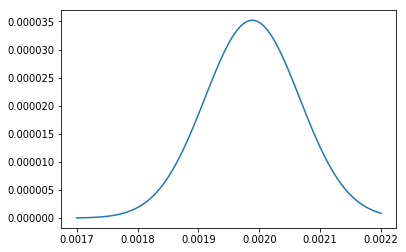

In [159]:
import scipy.integrate
#Each point in our new p(alpha) is an integral across our full distribution
#We'll just use scipy.integrate.quad
#Also, note that p(L0,alpha) = exp(-E(L0,alpha))

p_alpha_reduced = np.array([scipy.integrate.quad(lambda l: np.exp(-error_fun([l,a])), 1.13, 1.165)[0] for a in alphas])
plt.plot(alphas, p_alpha_reduced);

Ok, that's a nice Gaussian again (you can prove that had to happen if you want), so we just need to get the corresponding $\sigma$ out.  Since this is now a Gaussian, we find that going out one $\sigma$ gets us to

$$p(x = \mu + \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} 
\exp\left(-\frac{(\mu - (\mu + \sigma))^2}{2 \sigma^2}\right) = 
\exp\left(-\frac{1}{2}\right) \approx 0.607$$

So we just find where $p \approx 0.607$ and that's our point.  However, we might not have a properly normalized distribution at the moment (we don't), so we'll actually look for the point where the height is $0.607*p_{max}$

In [160]:
pmax = p_alpha_reduced.max()

#Same trick as before
error_bounds = alphas[p_alpha_reduced > pmax*np.exp(-0.5)][[0,-1]]
print("Measured value of α: {:0.6f} ± {:0.6f}".format(alpha, error_bounds[1] - alpha))

Measured value of α: 0.001988 ± 0.000075


This is about twice the naive estimate we had before, and this is an accurate reflection of the uncertainty.

Now, if you hadn't noticed, the issue lives in that step where we computed `p_alpha_reduced`. Here, we had to do a 100-point integral for each of our $\alpha$ values.  If there were two parameters to integrate out, we'd need to do a 2D, 100 x 100 point integral (so 10000 points).  If we have 20 parameters, we're in trouble, as each $\alpha$ requires a 20D, $2^{40}$ point integral.  And it's worse if we want to keep two parameters and integrate out 20, and so on.  We'll discuss a better way in a bit.

But we still have two unanswered questions from before: Are we always going to be a nice parabola?  What do we do if it's not?

Turns out the answer is no.  Often, especially for messy real-world data, we don't get a parabola there.  At this point in the old framework of reporting a single uncertainty, you're in trouble.  You could argue that you should always be able to zoom in enough to make it parabola-like around the minimum, but that isn't so good if it's not parabolic by the time you get out to one $\sigma$.  We currently have the full joint distribution, so we can just give the plot, or some other way of describing it.  Though, again, we're in trouble if we have more than a few parameters.

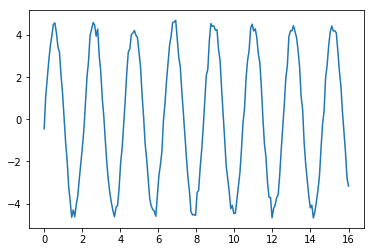

In [161]:
#I want to put an example where you don't get a parabola here
#I think fitting A*sin(k*x) would do the job
theta = np.linspace(0,16,200)
wave = 4.5 * np.sin(3*theta) + np.random.normal(0,0.2,size=200)
plt.plot(theta,wave);

In [162]:
def wave_error(pars):
    A = pars[0]
    k = pars[1]
    predict = A*np.sin(k*theta)
    return sum((predict - wave)**2)

results = scipy.optimize.minimize(wave_error, [4,3])
print(results)

      fun: 8.247254257777794
 hess_inv: array([[ 5.06219110e-03, -8.68035892e-07],
       [-8.68035892e-07,  2.78754005e-06]])
      jac: array([ 1.19209290e-07, -4.41074371e-06])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([4.51331639, 2.99944475])


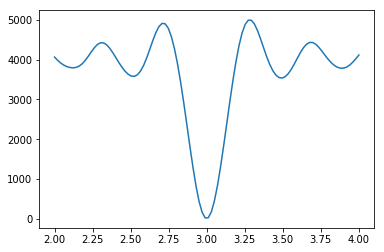

In [163]:
ks = np.linspace(2,4,100)
A = results.x[0]
k = results.x[1]
plt.plot(ks, [wave_error([A,myk]) for myk in ks]);

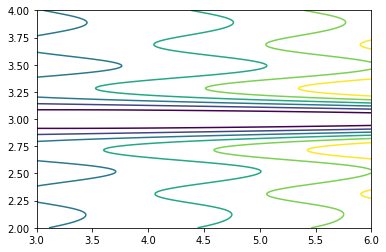

In [164]:
As = np.linspace(3,6,300)
ks = np.linspace(2,4,300)
[X_wave,Y_wave] = np.meshgrid(As,ks)
Z_wave = np.apply_along_axis(lambda x: wave_error(x), -1, np.stack([X_wave,Y_wave],axis=-1))
plt.contour(X_wave,Y_wave,Z_wave);

## Markov Chain Monte Carlo

Finally we arrive at the actual crux of this whole, long winded document.  If the underlying, physical values really do have probability distributions (in the sense that we have different levels of confidence in the values they could take), we should be able to get those distributions out, in a sense performing the ultimate act of statistics.

This is not so easy in practice, as we have seen, if we have more than a handful of parameters.  The integrals and related computations get out of hand very quickly.  But there's another way, again through the magic of modern computation.

In general, the way to avoid the problem of dimensions is to get a nice random sample of a distribution.  These are, effectively, immune to the problem because if you plot the histogram of a single variable, it _automatically_ is integrated across the remaining variables (but the size of the sample you need grows with the number of variables you want to plot simultaneously).  Let's see that in action.

I'll take our example of a measured rod again, just because it's convenient.  I want to use `scipy`'s built in multivariable normal distribution, but it needs $\Sigma$ rather than the $\Sigma^{-1}$ we need, so I'll invert the matrix while I'm at it.

Interesting side note: that original value we got for $\sigma_{\alpha}$, from the naive parabola estimate, is the same value you'd get if you took $\Sigma_{22} = \sigma_{\alpha}^{-2}$, with the $\Sigma$ matrix rather than the $\Sigma^{-1}$ that we computed.  It's the value it would have if the two parameters weren't correlated.

In [178]:
rod_sigma_inv = np.array([[dEdL02, dEdL0dalpha], [dEdL0dalpha, dEdalpha2]])
rod_sigma = np.linalg.inv(rod_sigma_inv)
rod_sigma

array([[ 2.33333333e-05, -3.33333333e-07],
       [-3.33333333e-07,  6.06060606e-09]])

In [189]:
yupper

0.002172778810278198

In [191]:
Ys

array([0.00179125, 0.00179531, 0.00179937, 0.00180343, 0.00180749,
       0.00181155, 0.00181561, 0.00181966, 0.00182372, 0.00182778,
       0.00183184, 0.0018359 , 0.00183996, 0.00184402, 0.00184807,
       0.00185213, 0.00185619, 0.00186025, 0.00186431, 0.00186837,
       0.00187243, 0.00187648, 0.00188054, 0.0018846 , 0.00188866,
       0.00189272, 0.00189678, 0.00190084, 0.0019049 , 0.00190895,
       0.00191301, 0.00191707, 0.00192113, 0.00192519, 0.00192925,
       0.00193331, 0.00193736, 0.00194142, 0.00194548, 0.00194954,
       0.0019536 , 0.00195766, 0.00196172, 0.00196577, 0.00196983,
       0.00197389, 0.00197795, 0.00198201, 0.00198607, 0.00199013,
       0.00199419, 0.00199824, 0.0020023 , 0.00200636, 0.00201042,
       0.00201448, 0.00201854, 0.0020226 , 0.00202665, 0.00203071,
       0.00203477, 0.00203883, 0.00204289, 0.00204695, 0.00205101,
       0.00205507, 0.00205912, 0.00206318, 0.00206724, 0.0020713 ,
       0.00207536, 0.00207942, 0.00208348, 0.00208753, 0.00209

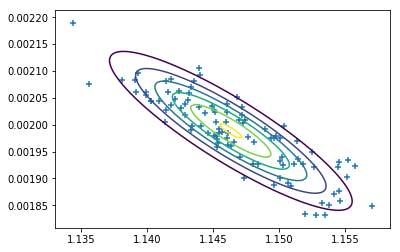

In [196]:
test_norm = scipy.stats.multivariate_normal([L0,alpha],rod_sigma)
samples = test_norm.rvs(size=100)

xlower = samples[:,0].min()
xupper = samples[:,0].max()
ylower = samples[:,1].min()
yupper = samples[:,1].max()
Xs = np.linspace(xlower,xupper,100)
Ys = np.linspace(ylower,yupper,100)
[X,Y] = np.meshgrid(Xs,Ys)
Z = np.apply_along_axis(lambda x: test_norm.pdf(x), -1, np.stack([X,Y],axis=-1))
plt.contour(X,Y,Z)
plt.scatter(samples[:,0], samples[:,1], marker='+');


With that out of the way, let's draw a lot more samples and do some plotting.  We'll get, say, 5000 samples, and look at the histogram for each of the variables ($X$ and $Y$).

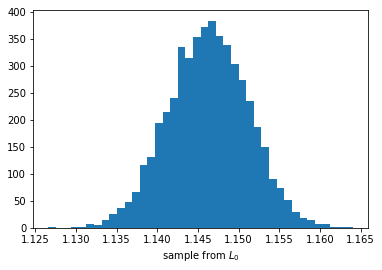

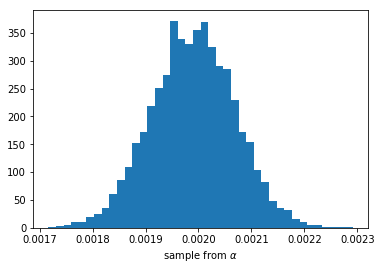

In [200]:
samples = test_norm.rvs(size=5000)

plt.hist(samples[:,0],bins=40);
plt.xlabel("sample from $L_0$");
plt.show()

plt.hist(samples[:,1],bins=40);
plt.xlabel(r"sample from $\alpha$")
plt.show()

We computed the proper uncertainty before (for $\alpha$).  We can compute it again.  This time, since we have a sample, we don't need to do any fits, we just need to compute the standard deviation of the sample.

In [201]:
samples[:,1].std()

7.883884974148844e-05

And we get (basically) the same value, without the integral mess this time!  Well then, this seems like the way to go.  If you're paying attention, you'll realize we did _a lot_ of work to get here, to the point where we had already computed the $\Sigma$ matrix.  Kind of defeats the purpose, doesn't it?

Hopefully you don't think I've led you this far down this path just to tell you it was a blind alley.  That would be a waste of your time and, more importantly, mine.  We need a method to sample the posterior directly from the likelihood.  That's a Markov Chain Monte Carlo.  We're here!  Finally!

